## M2 - release: regressions

### Setup

#### Imports

In [72]:
import pandas as pd
import numpy as np
from scipy import stats 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import learning_curve

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import RFE
from sklearn.decomposition import KernelPCA

from sklearn import metrics

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

sns.set_theme()
# Show plots
viz = True

In [73]:
class Feats():
    """
    Each feature has a first name, optionally a second name, a statistic and a number.
    This class allows to group feautures according to these aspects or combinations of these aspects.
    Each method produces a list of feature names or a list of lists of feature names.
    """

    def __init__(self, csv):
        self.fts = pd.read_csv(csv, dtype={'n':"string"})
        self.fts = self.fts.fillna('')

    def format(self, select):
        return select.apply(lambda x: '_'.join(x).replace('__', '_'), axis=1).tolist()

    def all(self):
        select = self.fts.copy()
        return self.format(select)

fts = Feats('features.csv')

#### Data

In [74]:
# Load fold f4
df_train = pd.read_csv('data/fold/f4_train.csv',  parse_dates=['release'])
df_train = df_train.drop(columns=['release'])
df_test = pd.read_csv('data/fold/f4_test.csv',  parse_dates=['release'])
df_test = df_test.drop(columns=['release'])
print(f'train set: {df_train.shape[0]:,} entries, test set: {df_test.shape[0]:,} entries, total: {df_train.shape[0]+df_test.shape[0]:,} entries')

train set: 68,207 entries, test set: 17,052 entries, total: 85,259 entries


### Preprocessing

In [75]:
# Drop NA and zero values train
n_orig = df_train.shape[0]
n_na = df_train['popularity'].isna().sum()
df_train = df_train.dropna(subset=['popularity'])
n_zero =df_train.loc[df_train['popularity']==0].shape[0]
df_train = df_train.loc[df_train['popularity']>0]

# Drop NA and zero values test
n_orig = df_test.shape[0]
n_na = df_test['popularity'].isna().sum()
df_test = df_test.dropna(subset=['popularity'])
n_zero =df_test.loc[df_test['popularity']==0].shape[0]
df_test = df_test.loc[df_test['popularity']>0]

# Scale X train and test
X_train = df_train.drop(columns=['popularity'])
X_test = df_test.drop(columns=['popularity'])
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=fts.all())
X_test = pd.DataFrame(X_test, columns=fts.all())

# Transform y train and test
y_train_before = df_train['popularity']
y_train = stats.boxcox(y_train_before)[0]
y_train = pd.Series(y_train)
y_test_before = df_test['popularity']
y_test = stats.boxcox(y_test_before)[0]
y_test = pd.Series(y_test)

# Use RFE to reduce features
estimator = LinearRegression()
red = RFE(estimator, n_features_to_select=45, step=5).fit(X_train, y_train)
X_train = red.transform(X_train)
X_test = red.transform(X_test)
cols = [x for x, y in zip(fts.all(), red.support_.tolist()) if y]
X_train = pd.DataFrame(X_train, columns=cols)
X_test = pd.DataFrame(X_test, columns=cols)

X_train


,chroma_cens_median_02,chroma_cens_median_06,chroma_cens_median_07,chroma_cens_mean_02,chroma_cens_mean_07,chroma_cens_mean_12,chroma_cqt_median_02,chroma_cqt_median_06,chroma_cqt_median_07,chroma_cqt_median_12,...,spectral_contrast_kurtosis_02,spectral_rolloff_median_01,spectral_rolloff_kurtosis_01,tonnetz_median_03,tonnetz_kurtosis_02,tonnetz_kurtosis_03,tonnetz_kurtosis_04,zcr_median_01,zcr_mean_01,zcr_kurtosis_01
0,1.326532,0.080302,0.073244,1.353038,0.270473,-0.955142,0.807195,0.089464,0.148457,-0.924694,...,0.705122,0.660966,2.591555,-1.374010,1.643156,-0.196497,-0.487730,-0.278289,-0.514290,0.648027
1,0.338013,1.035286,0.607966,0.059606,0.513504,-0.250559,0.573771,1.130039,0.760081,0.080696,...,-0.020702,0.005325,-0.436164,-0.354913,-1.087125,-0.338210,-0.810142,0.099513,0.256363,-0.566363
2,0.000737,-1.114838,0.101743,-0.160172,0.203438,-0.211223,-0.154225,-0.946467,-0.139741,-0.314253,...,0.618193,0.266126,-0.035395,0.920960,-0.118439,0.047630,-0.333299,-0.661962,-0.529703,-0.697468
3,0.777994,0.206402,0.435970,0.822314,0.359095,-0.049570,1.361131,0.693537,0.974309,0.502867,...,-0.388309,0.649961,-0.178457,0.039252,-0.743964,-1.002176,-1.477226,1.056311,0.965363,0.331536
4,-2.253011,-1.117163,-0.546940,-2.121163,-0.848880,-1.304949,-2.348663,-1.248661,-1.172182,-1.966324,...,0.476279,0.882548,0.824098,1.327345,0.383573,1.398307,1.902497,0.326973,0.364254,-0.114466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,-0.007621,0.502805,0.459924,-0.033767,0.488245,0.082946,0.168952,0.537348,0.589998,0.158068,...,0.912619,0.678146,2.004221,0.260210,-0.901825,-1.024833,-1.288378,1.883481,1.027016,3.186156
68202,-0.674443,-1.808071,-2.187507,-1.079595,-2.714872,-0.890229,-1.303807,-2.137391,-2.430527,-1.296171,...,3.187733,0.694399,-0.110334,-1.348242,1.218205,1.903465,2.339412,1.349773,1.443168,0.451143
68203,0.122295,0.424919,0.423958,0.230299,0.269740,0.106841,0.566244,0.660563,0.665892,0.305226,...,0.678090,-0.250553,0.059988,-0.379173,0.002981,-0.430956,-0.523149,-0.203380,-0.175203,-0.155487
68204,-0.637451,-0.087449,-1.085209,-2.270780,-1.923881,-2.474622,-1.906958,-0.832778,-1.818305,-3.394001,...,2.814113,-1.795375,-2.078088,1.433808,2.057435,1.073938,2.492264,-1.026138,-0.945856,-1.176492


### Models

In [76]:
scores = {}

In [77]:
def plt_curve(title, train_sizes, train_scores, test_scores, fit_times):
    """
    Code based on scikit learn example: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
    """
    # Values
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Init fig
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))

    # Plot learning curve
    axes[0].set_title(f'Learning curve (R2): {title}')
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes[0].plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    axes[0].legend(loc="best")
    
    # Plot n_samples vs fit_times
    axes[1].set_title("Scalability of the model")
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std, fit_times_mean + fit_times_std, alpha=0.1)
    
    # Plot fit_time vs score
    axes[2].set_title("Performance of the model")
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(fit_time_sorted, test_scores_mean_sorted - test_scores_std_sorted, test_scores_mean_sorted + test_scores_std_sorted, alpha=0.1)

    # Show fig
    axes[0].grid()
    axes[1].grid()
    axes[2].grid()
    plt.show()

#### Linear regression

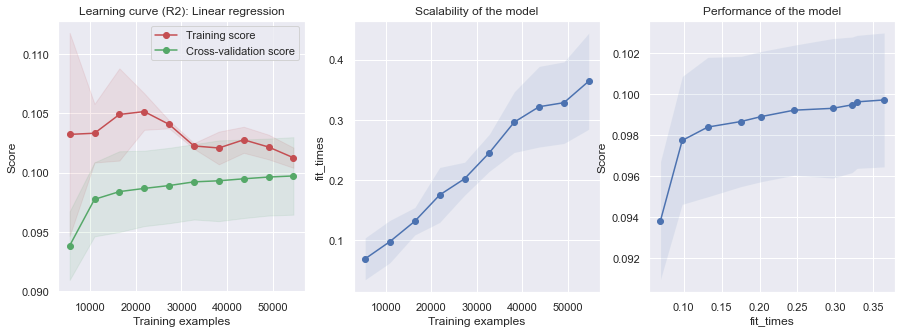

In [78]:
title = "Linear regression"
estimator = LinearRegression()
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X_train, y_train, cv=5, n_jobs=-1, train_sizes=train_sizes, return_times=True)

plt_curve(title, train_sizes, train_scores, test_scores, fit_times)

In [80]:
name = 'linear_regression'

# Subsample according to performance analysis with learning curve
idx_train = X_train.sample(frac=1, random_state=1).index
X_train_sub = X_train.iloc[idx_train]
y_train_sub = y_train.iloc[idx_train]
idx_test = X_test.sample(frac=1, random_state=1).index
X_test_sub = X_test.iloc[idx_test]
y_test_sub = y_test.iloc[idx_test]

model = LinearRegression().fit(X_train_sub, y_train_sub)
y_pred = model.predict(X_test_sub)

scores[name] = {
    'R2_train': round(model.score(X_train_sub, y_train_sub), 6),
    'R2_test': round(metrics.r2_score(y_test_sub, y_pred), 6),
    'MSE_test': round(metrics.mean_squared_error(y_test_sub, y_pred), 6),
    'MAE_test': round(metrics.mean_absolute_error(y_test_sub, y_pred), 6),
}

#### Elastic net

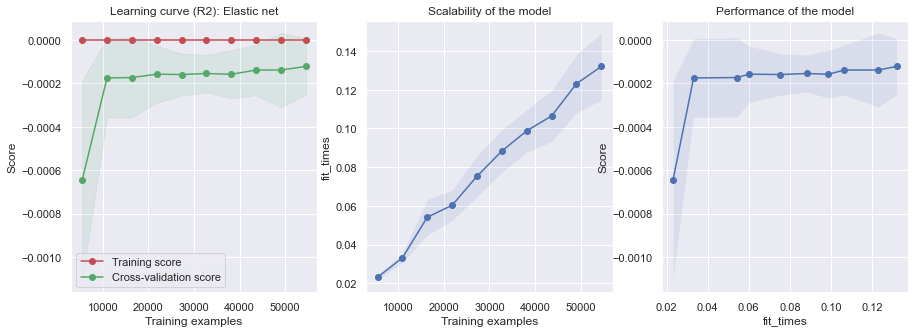

In [93]:
title = "Elastic net"
estimator = ElasticNet()
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X_train, y_train, cv=5, n_jobs=-1, train_sizes=train_sizes, return_times=True)

plt_curve(title, train_sizes, train_scores, test_scores, fit_times)

In [94]:
name = 'elastic_net'

# Subsample according to performance analysis with learning curve
idx_train = X_train.sample(frac=1, random_state=1).index
X_train_sub = X_train.iloc[idx_train]
y_train_sub = y_train.iloc[idx_train]
idx_test = X_test.sample(frac=1, random_state=1).index
X_test_sub = X_test.iloc[idx_test]
y_test_sub = y_test.iloc[idx_test]

model = ElasticNet().fit(X_train_sub, y_train_sub)
y_pred = model.predict(X_test_sub)

scores[name] = {
    'R2_train': round(model.score(X_train_sub, y_train_sub), 6),
    'R2_test': round(metrics.r2_score(y_test_sub, y_pred), 6),
    'MSE_test': round(metrics.mean_squared_error(y_test_sub, y_pred), 6),
    'MAE_test': round(metrics.mean_absolute_error(y_test_sub, y_pred), 6),
}

#### Polynomial regression

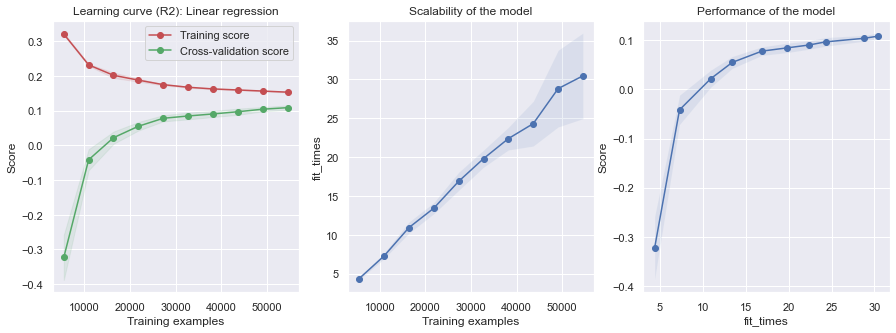

In [100]:
title = "Linear regression"
estimator = LinearRegression()
train_sizes = np.linspace(0.1, 1.0, 10)

poly = PolynomialFeatures(2)
X_train_poly = pd.DataFrame(poly.fit_transform(X_train))
X_test_poly = pd.DataFrame(poly.fit_transform(X_test))
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X_train_poly, y_train, cv=5, n_jobs=-1, train_sizes=train_sizes, return_times=True)

plt_curve(title, train_sizes, train_scores, test_scores, fit_times)

In [101]:
name = 'poly_linear_regression'

# Subsample according to performance analysis with learning curve
idx_train = X_train_poly.sample(frac=1, random_state=1).index
X_train_sub = X_train_poly.iloc[idx_train]
y_train_sub = y_train.iloc[idx_train]
idx_test = X_test_poly.sample(frac=1, random_state=1).index
X_test_sub = X_test_poly.iloc[idx_test]
y_test_sub = y_test.iloc[idx_test]

model = LinearRegression().fit(X_train_sub, y_train_sub)
y_pred = model.predict(X_test_sub)

scores[name] = {
    'R2_train': round(model.score(X_train_sub, y_train_sub), 6),
    'R2_test': round(metrics.r2_score(y_test_sub, y_pred), 6),
    'MSE_test': round(metrics.mean_squared_error(y_test_sub, y_pred), 6),
    'MAE_test': round(metrics.mean_absolute_error(y_test_sub, y_pred), 6),
}

#### SVR - support vector regression

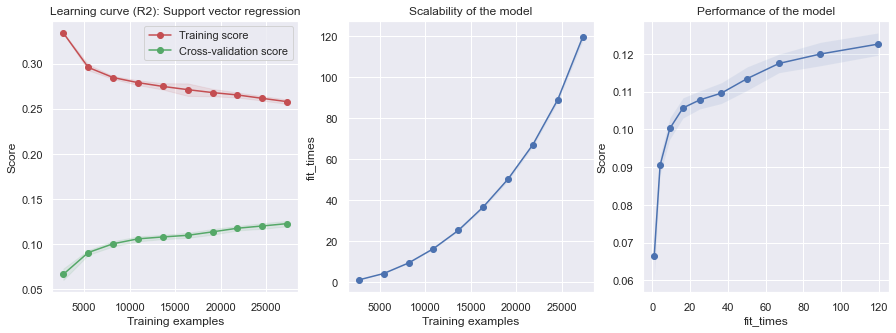

In [104]:
title = "Support vector regression"
estimator = SVR()
train_sizes = np.linspace(0.05, 0.5, 10)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X_train, y_train, cv=5, n_jobs=-1, train_sizes=train_sizes, return_times=True)

plt_curve(title, train_sizes, train_scores, test_scores, fit_times)

In [107]:
name = 'svr'

# Subsample according to performance analysis with learning curve
idx_train = X_train.sample(frac=0.5, random_state=1).index
X_train_sub = X_train.iloc[idx_train]
y_train_sub = y_train.iloc[idx_train]
idx_test = X_test.sample(frac=0.5, random_state=1).index
X_test_sub = X_test.iloc[idx_test]
y_test_sub = y_test.iloc[idx_test]

model = SVR().fit(X_train_sub, y_train_sub)
y_pred = model.predict(X_test_sub)

scores[name] = {
    'R2_train': round(model.score(X_train_sub, y_train_sub), 6),
    'R2_test': round(metrics.r2_score(y_test_sub, y_pred), 6),
    'MSE_test': round(metrics.mean_squared_error(y_test_sub, y_pred), 6),
    'MAE_test': round(metrics.mean_absolute_error(y_test_sub, y_pred), 6),
}

#### K-neighbors regression

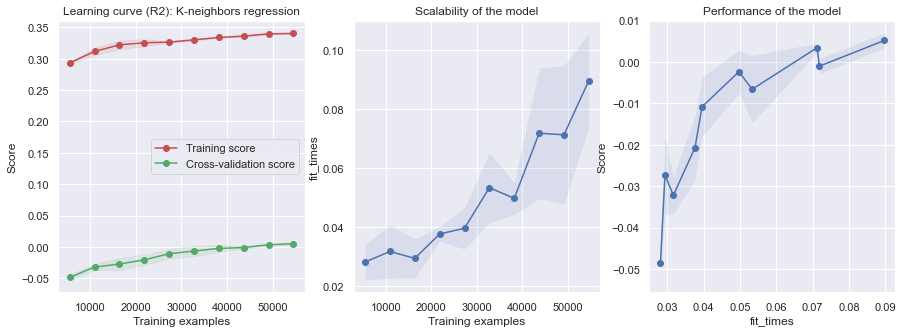

In [106]:
title = "K-neighbors regression"
estimator = KNeighborsRegressor()
train_sizes = np.linspace(0.1, 1, 10)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X_train, y_train, cv=5, n_jobs=-1, train_sizes=train_sizes, return_times=True)

plt_curve(title, train_sizes, train_scores, test_scores, fit_times)

In [108]:
name = 'k-neighbors'

# Subsample according to performance analysis with learning curve
idx_train = X_train.sample(frac=0.5, random_state=1).index
X_train_sub = X_train.iloc[idx_train]
y_train_sub = y_train.iloc[idx_train]
idx_test = X_test.sample(frac=0.5, random_state=1).index
X_test_sub = X_test.iloc[idx_test]
y_test_sub = y_test.iloc[idx_test]

model = KNeighborsRegressor().fit(X_train_sub, y_train_sub)
y_pred = model.predict(X_test_sub)

scores[name] = {
    'R2_train': round(model.score(X_train_sub, y_train_sub), 6),
    'R2_test': round(metrics.r2_score(y_test_sub, y_pred), 6),
    'MSE_test': round(metrics.mean_squared_error(y_test_sub, y_pred), 6),
    'MAE_test': round(metrics.mean_absolute_error(y_test_sub, y_pred), 6),
}

#### Results

In [109]:
pd.DataFrame.from_dict(scores, orient='index')

,R2_train,R2_test,MSE_test,MAE_test
linear_regression,0.101116,0.090442,1.591970,1.002757
elastic_net,0.000000,-0.001544,1.752970,1.053931
poly_linear_regression,0.149640,0.106391,1.564055,0.992515
svr,0.256202,0.116383,1.532355,0.980255
k-neighbors,0.334147,-0.015049,1.760283,1.049050
